In [315]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [4]:
# Read input data
sales_df = pd.read_csv('Resources/walmart_cleaned.csv', index_col=0)
sales_df.head(2)

,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,2010-02-05,0,1.0,24924.50,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
1,1,2010-02-05,0,26.0,11737.12,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315


In [57]:
sales_df['Date'] = pd.to_datetime(sales_df['Date'])
sales_df['week_of_year'] = sales_df['Date'].dt.isocalendar().week
sales_df['year'] = sales_df['Date'].dt.year
sales_df['month'] = sales_df['Date'].dt.month
sales_df['day'] = 1
sales_df['Year_Month'] = pd.to_datetime(sales_df[['year', 'month', 'day']])
sales_df['Year_Month'] = pd.to_datetime(sales_df['Year_Month'])
sales_df['ym_int'] = (sales_df['year'].astype(int) * 100) + sales_df['month'].astype(int)
sales_df.dtypes

Store                    int64
Date            datetime64[ns]
IsHoliday                int64
Dept                   float64
Weekly_Sales           float64
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
Type                     int64
Size                     int64
year                     int64
month                    int64
year_month               int32
day                      int64
Year_Month      datetime64[ns]
week_of_year            UInt32
IS_XMAS                  int64
IS_SUPERBOWL             int64
IS_TGIVING               int64
IS_LABORDAY              int64
ym_int                   int32
dtype: object

In [27]:
sales_df['IS_XMAS'] = 0
sales_df['IS_SUPERBOWL'] = 0
sales_df['IS_TGIVING'] = 0
sales_df['IS_LABORDAY'] = 0
sales_df.loc[sales_df['week_of_year'] == 6, 'IS_SUPERBOWL'] = 1
sales_df.loc[sales_df['week_of_year'] == 36, 'IS_SUPERBOWL'] = 1
sales_df.loc[sales_df['week_of_year'] == 47, 'IS_SUPERBOWL'] = 1
sales_df.loc[sales_df['week_of_year'] == 52, 'IS_SUPERBOWL'] = 1

In [37]:
temp_grouped = sales_df.groupby('Year_Month')['Weekly_Sales'].sum().reset_index()
temp_grouped

,Year_Month,Weekly_Sales
0,2010-02-01,1.903330e+08
1,2010-03-01,1.819198e+08
2,2010-04-01,2.314124e+08
3,2010-05-01,1.867109e+08
4,2010-06-01,1.922462e+08
5,2010-07-01,2.325801e+08
6,2010-08-01,1.876401e+08
7,2010-09-01,1.772679e+08
8,2010-10-01,2.171618e+08
9,2010-11-01,2.028534e+08


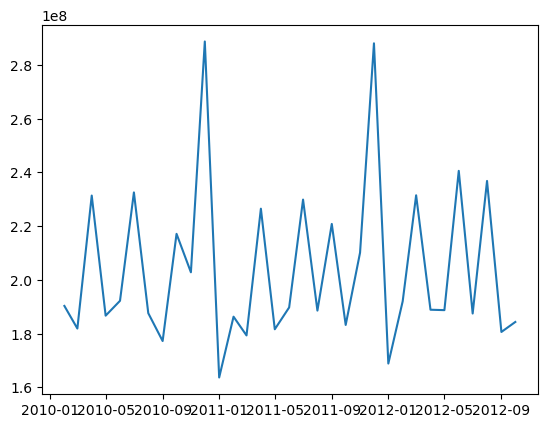

In [38]:
plt.plot(temp_grouped['Year_Month'], temp_grouped['Weekly_Sales'])

In [58]:
col_names = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size', 'ym_int',
             'IS_SUPERBOWL', 'IS_TGIVING', 'IS_XMAS', 'IS_LABORDAY']
sales_df_grouped = sales_df.groupby(['Year_Month'])[col_names].agg(
    {'Weekly_Sales': 'sum', 'Temperature': 'mean', 'Fuel_Price': 'mean', 'CPI': 'mean', 'Unemployment': 'mean', 'Size': 'mean',
     'IS_XMAS' : 'max', 'IS_SUPERBOWL' : 'max', 'IS_TGIVING' : 'max', 'IS_LABORDAY' : 'max', 'ym_int': 'min'}
).reset_index()

In [59]:
sales_df_grouped.shape

(33, 12)

In [184]:
# X = sales_df.copy()
X = sales_df_grouped.copy()
X.drop(columns=['Weekly_Sales', 'Year_Month'], axis=1, inplace=True)

X.head(2)

,Temperature,Fuel_Price,CPI,Unemployment,Size,IS_XMAS,IS_SUPERBOWL,IS_TGIVING,IS_LABORDAY,ym_int
0,35.578404,2.693286,167.452834,8.570455,137419.354506,0,1,0,0,201002
1,46.700687,2.786482,167.554940,8.575151,137379.993638,0,0,0,0,201003


In [185]:
# results in 143 rows of 1 array element each
y = sales_df_grouped['Weekly_Sales'].values.reshape(-1,1)
y[:5]

array([[1.90332983e+08],
       [1.81919802e+08],
       [2.31412368e+08],
       [1.86710934e+08],
       [1.92246172e+08]])

In [186]:
X.shape, y.shape

((33, 10), (33, 1))

In [351]:
# Split train and test (100 rows for train and 43 for test)
count = -11
X_train = X.iloc[:count]
X_test = X.iloc[count:]
print(X_train.shape)
print(X_test.shape)

(22, 10)
(11, 10)


In [352]:
# Split train and test (100 rows for train and 43 for test)
y_train = y[:count]
y_test = y[count:]
print(y_train.shape)
print(y_test.shape)

(22, 1)
(11, 1)


In [353]:
# Set x-axis values to be used
x_train_values = sales_df_grouped['Year_Month']
x_trvalues = x_train_values[:count]

x_test_values = sales_df_grouped['Year_Month']
x_tvalues = x_test_values[count:]

In [354]:
# Create the StandardScaler instance
scaler = StandardScaler()

# from sklearn.preprocessing import PowerTransformer
# scaler = PowerTransformer(method='yeo-johnson', standardize=False)

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

In [355]:
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

In [356]:
# Scale the training data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [357]:
rf_model = RandomForestRegressor(n_estimators=250, random_state=0)

In [358]:
# Fit the model and use .ravel()on the "y_train" data. 
rf_model = rf_model.fit(X_train_scaled, y_train.ravel())

In [359]:
# Making predictions for training data
y_train_pred = rf_model.predict(X_train_scaled)

In [360]:
r2_score(y_train, y_train_pred)

0.7552962834652929

Text(0.5, 1.0, 'Training Data Plot (Actual Vs Prediction)')

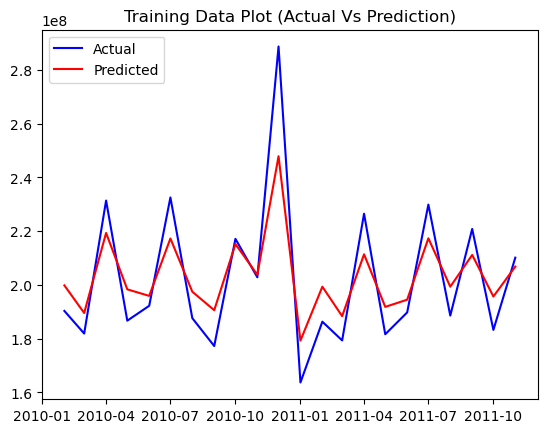

In [361]:
plt.plot(x_trvalues, y_train, color = "blue", label='Actual')
plt.plot(x_trvalues, y_train_pred, color = "red", label='Predicted')
plt.legend(loc='upper left')
plt.title('Training Data Plot (Actual Vs Prediction)')

In [362]:
# Making predictions for testing data
y_test_pred = rf_model.predict(X_test_scaled)

In [363]:

r2_score(y_test, y_test_pred)

0.0944319200734991

Text(0.5, 1.0, 'Testing Data Plot (Actual Vs Prediction)')

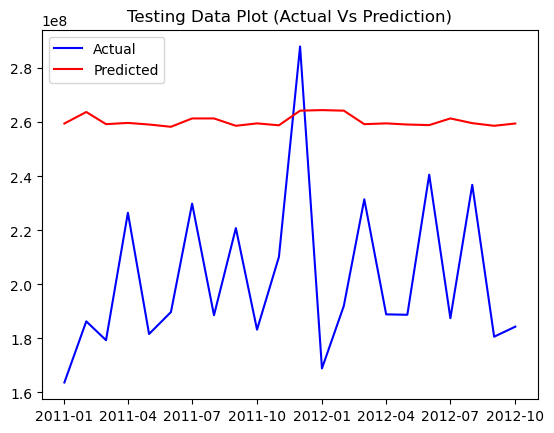

In [349]:
# Plot testing data
plt.plot(x_tvalues, y_test, color = "blue", label='Actual')
plt.plot(x_tvalues, y_test_pred, color = "red", label='Predicted')
plt.legend(loc='upper left')
plt.title('Testing Data Plot (Actual Vs Prediction)')

In [364]:
errors = abs(y_test_pred - y_test)
mape = 100 * np.mean(errors/y_test)
accuracy = 100 - mape
print(accuracy)

86.31231483229809
